# Simple predictions of successful funding - logistic regression

### _Lukas Vlcek_

## 1. Introduction

Kickstarter records contain more than 200,000 projects, with information about the ultimate success or failure of their funding campaign, the type of the proposed work, country of origin, or amounts of money asked and pledged by funders.

## 2. Data setup

Notebook configuration

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Create a dataframe from a pre-processed CSV file and filter out uninformative features

In [2]:
target_path = '../data/processed'
report_path = '../reports'
filename = 'kick_id.csv'
datecols = ['created_at', 'deadline', 'state_changed_at', 'launched_at']
fdatpars = lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
df = pd.read_csv(os.path.join(target_path, filename), index_col='id', parse_dates=datecols, date_parser=fdatpars)

Filter out unneeded data and add some indicator features

In [3]:
df = df.drop(['disable_communication'], axis='columns')
df = df.loc[(df['state'] != 'live') & (df['state'] != 'suspended')]
cat_type = [x.split('/')[0] for x in df['category'].values]
df['cat_type'] = np.array(cat_type)
df['dummy'] = 1
df['period'] = (df['launched_at'] >= '2014-06-01') & (df['launched_at'] < '2018-01-01')
df['succeeded'] = np.int_(df['state'] == 'successful')
df['staff_pick'] = np.int_(df['staff_pick'])
df.sort_values('launched_at').loc[df.period]['launched_at'].shape

(149007,)

In [4]:
#df['yes_blurb'] = df['blurb'].notnull()
#df = df.copy()
df.loc[df['blurb'].isnull(), 'blurb'] = ''
df.loc[df['name'].isnull(), 'name'] = ''
#df['blurb_len'] = df['blurb'].str.len()
#df['name_len'] = np.int_(df['name'].str.len())
df['blurb_wlen'] = df['blurb'].str.split().apply(len)
df['name_wlen'] = df['name'].str.split().apply(len)
#df['name_wlen'].apply(len)
df.loc[df['name_wlen'] == 0]

,name,goal,pledged,usd_pledged,state,slug,country,currency,deadline,state_changed_at,...,backers_count,blurb,spotlight,category,cat_type,dummy,period,succeeded,blurb_wlen,name_wlen
id,,,,,,,,,,,,,,,,,,,,,
796533179,,35000.0,220.0,220.0,failed,you-have-the-power-to-put-our-film-in-theaters,US,USD,2011-12-04 23:59:00,2011-12-04 23:59:02,...,5,,False,art/painting,art,1,False,0,0,0


In [5]:
# make new dataframes with new and old data
dfn = df.loc[df.period].copy()
dfo = df.loc[~df.period].copy()
dfn.shape, dfo.shape

((149007, 23), (89449, 23))

In [6]:
dfn['goal_log'] = np.log10(dfn['goal'].values)

In [7]:
dfm = dfn.drop(['usd_pledged','goal','state','slug','currency','deadline','state_changed_at','created_at','backers_count','spotlight','period'], axis=1).copy()

In [8]:
dfm.head()

,name,pledged,country,launched_at,staff_pick,blurb,category,cat_type,dummy,succeeded,blurb_wlen,name_wlen,goal_log
id,,,,,,,,,,,,,
18520,Grandma's are Life,62.0,US,2016-10-19 09:32:40,0,Raising money to help my grandmother recover f...,music/world music,music,1,0,24,3,4.176091
21109,Meta,173.0,GB,2015-04-07 18:37:44,0,My work is performance based but I branch out ...,art/performance art,art,1,1,24,1,2.176091
24380,Puss N' Books: A relaxing cat cafe and bookstore.,776.0,US,2015-10-27 11:25:33,0,A sanctuary for humans and felines alike! Come...,food/spaces,food,1,0,24,9,4.301030
33867,TASTE MAKERS BY TRISH P,2798.0,CA,2015-06-15 14:28:11,1,Taste Makers is a socially conscious brand tha...,fashion/ready-to-wear,fashion,1,0,23,5,4.255273
39036,The Meat Candy Experience,3239.0,US,2016-05-16 18:34:18,0,"The BEST beef sticks, beef jerky and signature...",food/small batch,food,1,1,13,4,3.397940


## 3. Modeling

In [9]:
# get dummies
dfd = pd.get_dummies(dfm, columns=['country','cat_type'])

In [10]:
# ML imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score

### 3.1 Logistic regression

In [11]:
predictors = []
predictors.extend([c for c in dfd.columns if c[0:5] == 'cat_t' ])
predictors.extend([c for c in dfd.columns if c[0:5] == 'count' ])

predictors.extend(['goal_log', 'staff_pick','name_wlen'])
#print(predictors)

In [12]:
X = dfd[predictors]
y = dfd.succeeded.values.astype(np.int)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
print(X.shape, Xtrain.shape, Xtest.shape, y.shape, ytrain.shape, ytest.shape)

(149007, 40) (111755, 40) (37252, 40) (149007,) (111755,) (37252,)


In [13]:
logreg = LogisticRegression(verbose=1, C=1e6)#, warm_start=True)

#print(logreg.intercept_, logreg.coef_)
logreg.fit(Xtrain, ytrain)
#logreg.intercept_ = 2.299
#logreg.coef_ = np.reshape(np.array([-0.6687]), (1,-1))
print(logreg.intercept_, logreg.coef_)

[LibLinear][ 1.71706373] [[-0.16987067  0.60490217 -0.43343734  0.88382185  1.63198352 -0.29847386
   0.49857629 -0.67230314  0.63112995 -0.89606821  0.32102437 -0.41882672
  -0.13522583 -0.52804778  0.69787914 -0.65289583 -0.21241277 -0.54399336
  -0.13074197 -0.00259038 -0.4669708   0.58298766 -0.56389925 -0.00921948
  -0.11755031  1.53574522 -0.30675562 -0.90862375  1.71717205  0.20515593
   0.39208196 -0.54003327  0.43327414  0.09986594  0.67431743  0.54760239
  -0.01545218 -0.85326779  2.5668446   0.11582474]]


In [14]:
y_pred = logreg.predict(Xtest)
y_pred_prob = logreg.predict_proba(Xtest)
print('Score:', logreg.score(Xtest, ytest))

Score: 0.722941050145


In [15]:
print('CV score:', cross_val_score(logreg, X, y, cv=5))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV score: [ 0.72310583  0.72823972  0.72438091  0.72148586  0.72677852]


In [16]:
y_pred = logreg.predict(Xtest)
y_pred_prob = logreg.predict_proba(Xtest)
print('Score:', logreg.score(Xtest, ytest))
#y_pred_cv = cross_val_predict(logreg, X, y, cv=3)
#y_pred_cv

Score: 0.722941050145


AUC 0.779893320128


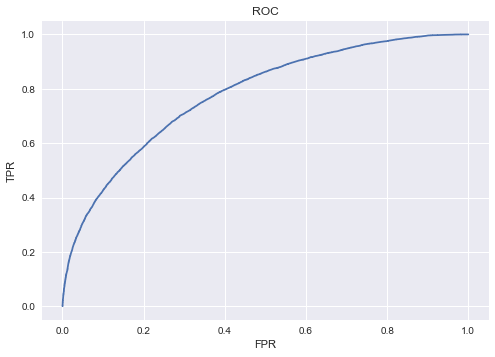

In [17]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

In [18]:
logregcv = LogisticRegressionCV(verbose=1, cv=3, Cs=[0.1, 1.0, 100.0])#, warm_start=True)
logregcv.fit(X, y)
print(logregcv.coef_)

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:717: UserWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number "
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.7s finished


[[-0.25336855  0.5355078  -0.49356338  0.71553703  1.54148709 -0.39587553
   0.38905822 -0.76084639  0.54405147 -0.99712954  0.2171546  -0.52709592
  -0.22253547 -0.61154936  0.61848838 -0.54107572 -0.22347114 -0.4328734
  -0.14419361  0.00645309 -0.51479786  0.59907814 -0.51174083 -0.01613123
  -0.12510083  1.21752482 -0.22033232 -0.87837014  0.63370487  0.27120535
   0.35413645 -0.51254441  0.34058754  0.04148009  0.58180401  0.39397512
  -0.01999754 -0.83717621  2.53905235  0.11488122]]


Score: 0.723612155052
AUC 0.780120371045


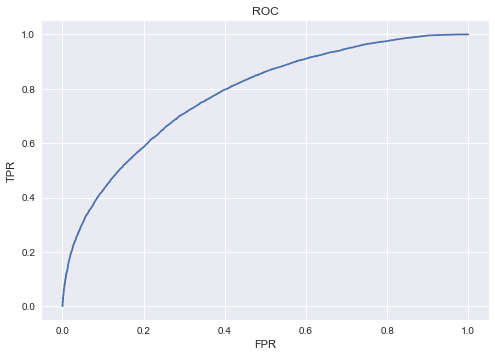

In [19]:
y_pred = logregcv.predict(Xtest)
y_pred_prob = logregcv.predict_proba(Xtest)
print('Score:', logregcv.score(Xtest, ytest))
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

### 3.2 Naive Bayes for text analysis 

In [20]:
# Vectorize project names and blurbs
#vectorizer = TfidfVectorizer(min_df=1)
vectorizer = CountVectorizer(min_df=2, max_df=2000)

# project name
Xn = vectorizer.fit_transform(dfn.name).tocsc()
fn_names = vectorizer.get_feature_names()

# project blurb
dfn.blurb.fillna('', inplace=True)
Xb = vectorizer.fit_transform(dfn.blurb).tocsc()
fb_names = vectorizer.get_feature_names()

y = dfn.succeeded.values.astype(np.int)

print(Xn.shape, Xb.shape, y.shape, len(fn_names), len(fb_names))

(149007, 28409) (149007, 40288) (149007,) 28409 40288


Simple training without cross validation

In [21]:
# NB for names

# train-test split
Xntrain, Xntest, ytrain, ytest = train_test_split(Xn, y)

# Create instance of multinomial naive bayes
mnb_n = MultinomialNB()

# fit to training data
mnb_n.fit(Xntrain, ytrain)

print("Train set score:", mnb_n.score(Xntrain, ytrain))
print("Test set score:", mnb_n.score(Xntest, ytest))

Train set score: 0.752100577155
Test set score: 0.667964136154


In [22]:
# NB for blurbs

# train-test split
Xbtrain, Xbtest, ytrain, ytest = train_test_split(Xb, y)

# Create instance of multinomial naive bayes
mnb_b = MultinomialNB()

# fit to training data
mnb_b.fit(Xbtrain, ytrain)

print("Train set score:", mnb_b.score(Xbtrain, ytrain))
print("Test set score:", mnb_b.score(Xbtest, ytest))

Train set score: 0.754820813386
Test set score: 0.689922688715


In [23]:
#the grid of parameters to search over
param_grid = {'alpha':np.logspace(0.1, 100, 10)}
              
mnb = MultinomialNB()
mnb_cv = GridSearchCV(mnb, param_grid, cv=5, verbose=1)
mnb_cv.fit(Xn, y)

print('Best alpha', mnb_cv.best_params_)
print('Best score', mnb_cv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best alpha {'alpha': 1.2589254117941673}
Best score 0.67199527539


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.5s finished
